In [1]:
##### Diffusion in Koch-like boundary @ YYE
##### April 2023
##### Generate Koch triangle with arbitraty angles
##### Diffusion and contact PDF.

import numpy as np
import matplotlib.pyplot as plt
import math, random
from itertools import cycle


Here, we could have already generated all coordinates for any Koch-like configurations with arbitrary angles. Next, we would like to consider the diffusion inside such a boundary. To be exact, we consider $p_k$ as the **Probability** that particles attach to *k*-th segment of the whole boundary. 

Define
$$ \zeta_q = \sum_k (p_k)^q 
\ \ \ \ \ \ \ \ \ \ 
\zeta_1 = \sum_k p_k = 1
$$
We want to figure out the Probability Distribution Function (PDF) or Histogram of $p_k$ and how $\zeta_q$ evoles, for a Koch-like shape with recursion generation as $g=0, 1, \cdots 10$.

In our case, $d_f = 4/3$, namely we insert 3 new points for each edge. As for $g=10$, there would be $a \times 4^{10}$ points totally, where $a$ refers to polygon vertex number. It's quite a big trouble to record all these coordinates and do ``for`` loops for large $g$. Therefore, we try to generate sub-leading generation points during the diffusion process.

To sum up, we follow the below process:

1. Generate initial configuration (polygon coordinates) by ``Koch_generate``;
2. Define ``distance`` function to return minimum distance toward two given points;
3. Between -> ynew; dehors -> min(d1,d2);
4. Iterate until ``distance`` returns ``arret=1``;
5. Find the exact segment index and the related counter +1;
6. Loop for $N=10^6$ particles and obtain $p_k$;
    
    


In [2]:
def koch_line(start, end, alpha, direction):
    """
    Segments a line to Koch line, creating fractals.
    :param tuple start:  (x, y) coordinates of the starting point
    :param tuple end: (x, y) coordinates of the end point
    :alpha: angle for Koch triangle (unit: rad)
    :direction: 凹(+1)凸(-1), concave or convex?
    ~returns tuple: tuple of three points between the segmentation
    """
    
    x1, y1 = start[0], start[1] # coordinates of the start
    x2, y2 = end[0], end[1]     # coordinates of the end
    
    # the length of the line
    deltax, deltay = x2 - x1, y2 - y1
    l = np.sqrt((deltax)**2 + (deltay)**2)
    coef = np.sqrt( 2 * (1 - np.cos(alpha)) ) + 2
    segm = l / (coef)
    #dist = segm * coef
    beta = (np.pi - alpha)/2
    if x1==x2:
        if y1<y2:
            theta = + np.pi / 2
        if y1>y2:
            theta = - np.pi / 2
    else:
        theta = np.arctan((deltay)/(deltax))
    if x1>x2:
        theta += np.pi
    
    changex, changey = (deltax)/(coef), (deltay)/(coef)
    # second point: one third in each direction from the first point
    b = (x1+changex, y1+changey)
    # third point: rotation for multiple of 60 degrees
    degree = theta + beta * direction
    c = (b[0] + segm * np.cos(degree), b[1] + segm * np.sin(degree))
    # fourth point: two thirds in each direction from the first point
    d = (x2-changex, y2-changey)
    
    return [b, c, d]





def Koch_generate(polygon, edge, angle, concave, generation):
    
    ## General initial coordinates
    initial_shape = polygon # 3 = triangle, 4 = square, 5 = star, etc.
    edge_length = edge # Initial edge length
    angle_ini = 2.0 * np.pi / initial_shape
    coordinate = []
    #new_x, new_y = 0, 0
    ## Move the polygon center as (0,0)
    tta = np.pi * (1 - 2/polygon)
    new_x, new_y = - edge_length/2, - edge_length/2 * np.tan(tta/2)

    for i in range(initial_shape):
        coordinate.append((new_x,new_y))
        new_x += edge_length * np.cos(i * angle_ini)
        new_y += edge_length * np.sin(i * angle_ini)
    coordinate.append(coordinate[0]) # To form a circle.

    
    max_degree = generation # Define the recursion order
    degre = angle # Define the fractal angle
    direction = concave # Define 凹(concave +1) 凸(convex -1)
    for i in range(max_degree): ## Recursion Order
        num_edge = len(coordinate)
        for j in range(num_edge-1): ## How many times to insert new points?
            num_point = j * 4
            coordinate = coordinate[:num_point+1] + koch_line(coordinate[num_point],coordinate[num_point+1],degre,direction) + coordinate[num_point+1:]

    return coordinate

In [18]:
def distance(start,end,particle):
    x1, y1 = start[0], start[1] # coordinates of the start
    x2, y2 = end[0], end[1] # coordinates of the end

    deltax, deltay = x2 - x1, y2 - y1
    #ell = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    ell = np.sqrt(deltax**2 + deltay**2)
    eps = ell / 10**3
    
    if x1 == x2:
        if y1 <= y2:
            theta = + np.pi / 2
        else:
            theta = - np.pi / 2
    else:
        theta = np.arctan(deltay/deltax)
    if x1 > x2:
        theta += np.pi
    st, ct = np.sin(theta), np.cos(theta)
    
    x0, y0 = particle[0], particle[1] # particle's coordiante
    xdist, ydist = x0 - x1, y0 - y1
    #xnew = x1 + ct * xdist + st * ydist
    dxnew = + ct * xdist + st * ydist
    #ynew = y1 - st * xdist + ct * ydist
    dynew = - st * xdist + ct * ydist
    
    if (dxnew >= 0) and (dxnew <= ell):
        dehors, dmin = 0, dynew
        #if ynew > 0: ## Suppose that particles would not leave the boundary
        #if dynew <= eps:
        #    arret = 1
        #else:
        #    arret = 0
    else:
        d1 = np.sqrt((x0-x1)**2 + (y0-y1)**2)
        d2 = np.sqrt((x0-x2)**2 + (y0-y2)**2)
        #arret = 0
        if d1 <= d2:
            dehors, dmin = 1, d1
        else:
            dehors, dmin = 2, d2
            
    if dmin<=eps:
        arret = 1
    else: 
        arret = 0
        
    return arret, dehors, dmin

CPU times: user 1.54 s, sys: 22.4 ms, total: 1.56 s
Wall time: 1.56 s


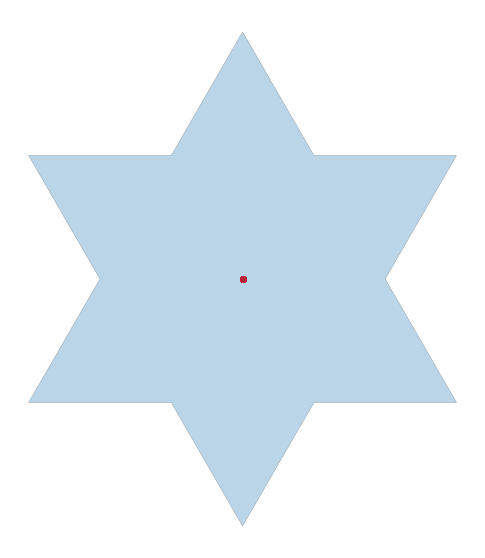

In [40]:
%%time
Length = 200
Generation_max = 1
coordinate = Koch_generate(3,Length,np.pi/3,-1,Generation_max)
# Extract all coordinates
pos_x = []
pos_y = []
for i in range(len(coordinate)):
    pos_x.append(coordinate[i][0])
    pos_y.append(coordinate[i][1])
    

count = np.zeros(len(coordinate))
num_particle = 10**6
particle_x, particle_y = np.zeros(num_particle), np.zeros(num_particle)
#particle_x[:] = np.mean(pos_x)
#particle_y[:] = np.mean(pos_y)


# fill the polygons
plt.figure(figsize=(10,10))
plt.fill(pos_x, pos_y, edgecolor='black', lw=0.5, alpha = 0.3)
plt.scatter(particle_x,particle_y,color='red')
plt.axis('off')
plt.axis('scaled')
plt.show

In [41]:
%%time
traj = []
for i in range(num_particle):
    traj.append([])
for i in range(num_particle):
    traj[i].append((particle_x[i], particle_y[i]))

CPU times: user 1.15 s, sys: 100 ms, total: 1.25 s
Wall time: 1.25 s


CPU times: user 28min 5s, sys: 6.63 s, total: 28min 12s
Wall time: 28min 20s


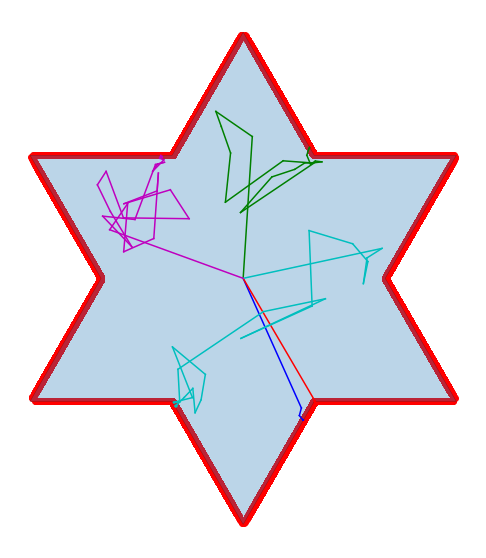

In [42]:
%%time
for i in range(num_particle):
    halt = 0
    while True: ## Continuous diffusion until touching boundary
        radius_min = Length # Length = the length of polygon edge. Update radius min for each step
        for j in range(len(coordinate)-1):
            stop, case, radius = distance(coordinate[j],coordinate[j+1],(particle_x[i], particle_y[i]))
            #print(i,j,stop,case,radius)
            if radius_min >= radius:
                radius_min = radius
                k = j
            if stop==1:
                halt = 1
            #    k = j
                #break
        if halt!=1: #radius_min < ?: #stop!=1:
            random_angle = random.uniform(0,2*np.pi)
            move_x = radius_min * np.cos(random_angle)
            move_y = radius_min * np.sin(random_angle)
            particle_x[i] += move_x
            particle_y[i] += move_y
            traj[i].append((particle_x[i], particle_y[i]))
        else:
            count[k] += 1     ## Re-construct segment index?
            break

# fill the polygons
plt.figure(figsize=(10, 10))
plt.fill(pos_x, pos_y, edgecolor='black', lw=0.5, alpha = 0.3)
cycol = cycle('bgrcmk')
for i in range(5):
    random_color = next(cycol)
    for j in range(len(traj[i])-1):
        plt.plot([traj[i][j][0],traj[i][j+1][0]],[traj[i][j][1],traj[i][j+1][1]],'-',c=random_color)
plt.scatter(particle_x,particle_y,color='red')
plt.axis('off')
plt.axis('scaled')
plt.show

In [43]:
count

array([83002., 82787., 83345., 82974., 83688., 83124., 83816., 83374.,
       83215., 83934., 83182., 83559.,     0.])

In [44]:
count /= np.sum(count)
count

array([0.083002, 0.082787, 0.083345, 0.082974, 0.083688, 0.083124,
       0.083816, 0.083374, 0.083215, 0.083934, 0.083182, 0.083559,
       0.      ])

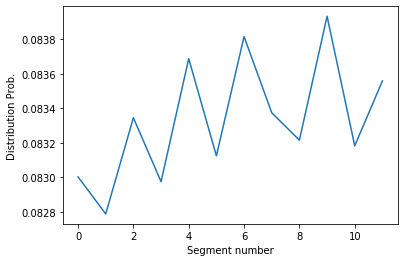

In [73]:
plt.xlabel("Segment number")
plt.ylabel("Distribution Prob.")
plt.plot(count[:-1])

In [55]:
qmax = 10
zeta = np.zeros(qmax)
for i in range(1,qmax+1):
    #print("i=",i,np.sum(count**i))
    zeta[i-1] = np.sum(count**i)
    print(zeta[i-1])

1.0
0.083334723712
0.006944792164314203
0.0005787616782058367
4.823336364424401e-05
4.01978297458487e-06
3.350155345858575e-07
2.792123177372049e-08
2.3270809848001932e-09
1.9395265250063322e-10


In [56]:
zeta

array([1.00000000e+00, 8.33347237e-02, 6.94479216e-03, 5.78761678e-04,
       4.82333636e-05, 4.01978297e-06, 3.35015535e-07, 2.79212318e-08,
       2.32708098e-09, 1.93952653e-10])

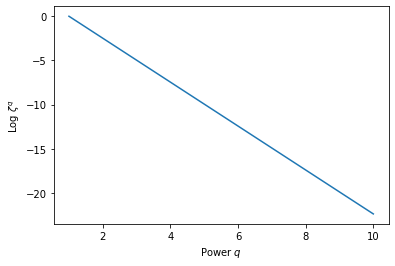

In [72]:
q = np.linspace(1,10,10)
plt.xlabel("Power $q$")
plt.ylabel("Log $\zeta^q$")
plt.plot(q,np.log(zeta))